 # ネットワーク可制御性解析の例
ノードの分類（「不必要」「中立」「不可欠」）とDrug targetの関連性を調査


In [6]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy import stats


import matplotlib.pyplot as plt
import pulp
from utils import *

## 乳がんタンパク質相互作用ネットワークの読み込み
* エッジリスト形式
* 有向ネットワーク
* Kanhaiya K, Czeizler E, Gratie C, Petre I (2017) Controlling directed protein interaction networks in cancer. Sci Rep 7, 10327. doi: 10.1038/s41598-017-10491-y


In [7]:
d = pd.read_csv("../data/breast_cancer_directed_ppi_Kanhaiya_etal_2017.csv", header=0, sep=",", engine='python')
g = nx.from_pandas_edgelist(d, edge_attr=None, create_using=nx.DiGraph())
Gcc = sorted(nx.strongly_connected_components(g), key=len, reverse=True)
Gcc_w = sorted(nx.weakly_connected_components(g), key=len, reverse=True)
g = g.subgraph(Gcc[0])
g = nx.DiGraph(g)
g.remove_edges_from(nx.selfloop_edges(g))


In [8]:
len(g.nodes()), len(g.edges())

(202, 646)

## 最大マッチングに基づくネットワーク可制御性に基づくいてノードを分類する

In [9]:
node_class = node_classification_controllability(g, get_mds=get_mds_matching)

## Drug targetのリストを読み込む
アメリカ食品医薬品局が承認した（FDA-approved）薬剤標的タンパク質のリスト

Kanhaiya K, Czeizler E, Gratie C, Petre I (2017) Controlling directed protein interaction networks in cancer. Sci Rep 7, 10327. doi: 10.1038/s41598-017-10491-y


In [10]:
drug_target = pd.read_csv("../data/drug_target_proteins.csv")


In [11]:
target = []
for node in g.nodes():
    if node in drug_target["target"].values:
        target.append("target")
    else:
        target.append("non_targete")


In [12]:
df = pd.DataFrame(np.array([node_class, target]).T, columns=["node_class", "target"])

In [15]:
conf_table = pd.crosstab(index=df["node_class"], columns=df['target'])
conf_table


target,non_targete,target
node_class,,
dispensable,68,4
indispensable,35,15
neutral,65,15


## 各ノードクラスにおけるDrug targetの割合を計算し，プロット

In [43]:
target_ratio = []
for i in range(3):
    target_ratio.append(conf_table.iloc[i, 1] / conf_table.iloc[i,:].sum())


In [44]:
target_ratio

[0.05555555555555555, 0.3, 0.1875]

<BarContainer object of 3 artists>

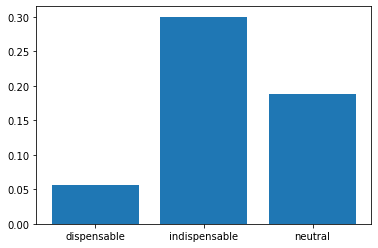

In [50]:
plt.bar([0, 1, 2], target_ratio, tick_label=["dispensable", "indispensable", "neutral"])

## 関連性を統計検定（エンリッチメント解析）

In [54]:
oddsratio, pvalue = stats.fisher_exact(conf_table.values)

ValueError: The input `table` must be of shape (2, 2).